In [ ]:
# default_exp exp.csnc.java

# Data exploration (taken from CodeSearchNet challenge)

In [ ]:
import json

import pandas as pd
from pathlib import Path
pd.set_option('max_colwidth',300)
from pprint import pprint
import re

## Preview dataset

Download specific java dataset

In [ ]:
!wget https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/java.zip

--2020-05-24 21:32:35--  https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/java.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.79.38
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.79.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1060569153 (1011M) [application/zip]
Saving to: ‘java.zip’

java.zip            100%[===================>]   1011M  11.3MB/s    in 92s     

2020-05-24 21:34:08 (11.0 MB/s) - ‘java.zip’ saved [1060569153/1060569153]



In [ ]:
!unzip java.zip

Archive:  java.zip
   creating: java/
   creating: java/final/
   creating: java/final/jsonl/
   creating: java/final/jsonl/train/
  inflating: java/final/jsonl/train/java_train_12.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_9.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_3.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_5.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_7.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_1.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_10.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_14.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_0.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_6.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_8.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_15.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_2.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_4.jsonl.gz  
  inflating: java/final/j

In [ ]:
!gzip -d java/final/jsonl/test/java_test_0.jsonl.gz

In [ ]:
with open('test_data/java/final/jsonl/test/java_test_0.jsonl', 'r') as f:
    sample_file = f.readlines()
sample_file[0]

'{"repo": "ReactiveX/RxJava", "path": "src/main/java/io/reactivex/internal/observers/QueueDrainObserver.java", "func_name": "QueueDrainObserver.fastPathOrderedEmit", "original_string": "protected final void fastPathOrderedEmit(U value, boolean delayError, Disposable disposable) {\\n        final Observer<? super V> observer = downstream;\\n        final SimplePlainQueue<U> q = queue;\\n\\n        if (wip.get() == 0 && wip.compareAndSet(0, 1)) {\\n            if (q.isEmpty()) {\\n                accept(observer, value);\\n                if (leave(-1) == 0) {\\n                    return;\\n                }\\n            } else {\\n                q.offer(value);\\n            }\\n        } else {\\n            q.offer(value);\\n            if (!enter()) {\\n                return;\\n            }\\n        }\\n        QueueDrainHelper.drainLoop(q, observer, delayError, disposable, this);\\n    }", "language": "java", "code": "protected final void fastPathOrderedEmit(U value, boolean d

In [ ]:
print(type(sample_file))
print(len(sample_file))

<class 'list'>
26909


In [ ]:
pprint(json.loads(sample_file[0]))

Pretty printing has been turned OFF


## Exploring the full DataSet

In [ ]:
!ls test_data/java/

_sp_bpe_modal.model  _sp_bpe_modal.vocab  final  text.txt


In [ ]:
!ls test_data/java/final/jsonl

test  train  valid


In [ ]:
java_files = sorted(Path('test_data/java/final/jsonl/').glob('**/*.gz'))

In [ ]:
java_test_files

[PosixPath('test_data/java/final/jsonl/test/java_test_0.jsonl')]

In [ ]:
print('Total of related java files: {}'.format(len(java_files)))

Total of related java files: 18


In [ ]:
pprint(java_files)

[PosixPath('test_data/java/final/jsonl/test/java_test_0.jsonl.gz'),
 PosixPath('test_data/java/final/jsonl/train/java_train_0.jsonl.gz'),
 PosixPath('test_data/java/final/jsonl/train/java_train_1.jsonl.gz'),
 PosixPath('test_data/java/final/jsonl/train/java_train_10.jsonl.gz'),
 PosixPath('test_data/java/final/jsonl/train/java_train_11.jsonl.gz'),
 PosixPath('test_data/java/final/jsonl/train/java_train_12.jsonl.gz'),
 PosixPath('test_data/java/final/jsonl/train/java_train_13.jsonl.gz'),
 PosixPath('test_data/java/final/jsonl/train/java_train_14.jsonl.gz'),
 PosixPath('test_data/java/final/jsonl/train/java_train_15.jsonl.gz'),
 PosixPath('test_data/java/final/jsonl/train/java_train_2.jsonl.gz'),
 PosixPath('test_data/java/final/jsonl/train/java_train_3.jsonl.gz'),
 PosixPath('test_data/java/final/jsonl/train/java_train_4.jsonl.gz'),
 PosixPath('test_data/java/final/jsonl/train/java_train_5.jsonl.gz'),
 PosixPath('test_data/java/final/jsonl/train/java_train_6.jsonl.gz'),
 PosixPath('test

In [ ]:
columns_long_list = ['repo', 'path', 'url', 'code', 
                     'code_tokens', 'docstring', 'docstring_tokens', 
                     'language', 'partition']

columns_short_list = ['code_tokens', 'docstring_tokens', 
                      'language', 'partition']

# export
def jsonl_list_to_dataframe(file_list, columns=columns_long_list):
    """Load a list of jsonl.gz files into a pandas DataFrame."""
    return pd.concat([pd.read_json(f, 
                                   orient='records', 
                                   compression='gzip',
                                   lines=True)[columns] 
                      for f in file_list], sort=False)

# export
def plain_json_list_to_dataframe(file_list, columns):
    '''Load a list of jsonl files into a pandas DaraFrame.'''
    return pd.concat([pd.read_json(f,
                                   orients='records',
                                   compression=None,
                                   lines=True)[columns]
                         for f in file_list], sort=False)

In [ ]:
java_df = jsonl_list_to_dataframe(java_files)

In [ ]:
java_df.head()

,repo,path,url,code,code_tokens,docstring,docstring_tokens,language,partition
0,ReactiveX/RxJava,src/main/java/io/reactivex/internal/observers/QueueDrainObserver.java,https://github.com/ReactiveX/RxJava/blob/ac84182aa2bd866b53e01c8e3fe99683b882c60e/src/main/java/io/reactivex/internal/observers/QueueDrainObserver.java#L88-L108,"protected final void fastPathOrderedEmit(U value, boolean delayError, Disposable disposable) {\n final Observer<? super V> observer = downstream;\n final SimplePlainQueue<U> q = queue;\n\n if (wip.get() == 0 && wip.compareAndSet(0, 1)) {\n if (q.isEmpty()) {\n ...","[protected, final, void, fastPathOrderedEmit, (, U, value, ,, boolean, delayError, ,, Disposable, disposable, ), {, final, Observer, <, ?, super, V, >, observer, =, downstream, ;, final, SimplePlainQueue, <, U, >, q, =, queue, ;, if, (, wip, ., get, (, ), ==, 0, &&, wip, ., compareAndSet, (, 0, ...","Makes sure the fast-path emits in order.\n@param value the value to emit or queue up\n@param delayError if true, errors are delayed until the source has terminated\n@param disposable the resource to dispose if the drain terminates","[Makes, sure, the, fast, -, path, emits, in, order, .]",java,test
1,ReactiveX/RxJava,src/main/java/io/reactivex/Observable.java,https://github.com/ReactiveX/RxJava/blob/ac84182aa2bd866b53e01c8e3fe99683b882c60e/src/main/java/io/reactivex/Observable.java#L118-L124,"@CheckReturnValue\n @NonNull\n @SchedulerSupport(SchedulerSupport.NONE)\n public static <T> Observable<T> amb(Iterable<? extends ObservableSource<? extends T>> sources) {\n ObjectHelper.requireNonNull(sources, ""sources is null"");\n return RxJavaPlugins.onAssembly(new Obser...","[@, CheckReturnValue, @, NonNull, @, SchedulerSupport, (, SchedulerSupport, ., NONE, ), public, static, <, T, >, Observable, <, T, >, amb, (, Iterable, <, ?, extends, ObservableSource, <, ?, extends, T, >, >, sources, ), {, ObjectHelper, ., requireNonNull, (, sources, ,, ""sources is null"", ), ;,...","Mirrors the one ObservableSource in an Iterable of several ObservableSources that first either emits an item or sends\na termination notification.\n<p>\n<img width=""640"" height=""385"" src=""https://raw.github.com/wiki/ReactiveX/RxJava/images/rx-operators/amb.png"" alt="""">\n<dl>\n<dt><b>Scheduler:</...","[Mirrors, the, one, ObservableSource, in, an, Iterable, of, several, ObservableSources, that, first, either, emits, an, item, or, sends, a, termination, notification, ., <p, >, <img, width, =, 640, height, =, 385, src, =, https, :, //, raw, ., github, ., com, /, wiki, /, ReactiveX, /, RxJava, /,...",java,test
2,ReactiveX/RxJava,src/main/java/io/reactivex/Observable.java,https://github.com/ReactiveX/RxJava/blob/ac84182aa2bd866b53e01c8e3fe99683b882c60e/src/main/java/io/reactivex/Observable.java#L144-L158,"@SuppressWarnings(""unchecked"")\n @CheckReturnValue\n @NonNull\n @SchedulerSupport(SchedulerSupport.NONE)\n public static <T> Observable<T> ambArray(ObservableSource<? extends T>... sources) {\n ObjectHelper.requireNonNull(sources, ""sources is null"");\n int len = sources...","[@, SuppressWarnings, (, ""unchecked"", ), @, CheckReturnValue, @, NonNull, @, SchedulerSupport, (, SchedulerSupport, ., NONE, ), public, static, <, T, >, Observable, <, T, >, ambArray, (, ObservableSource, <, ?, extends, T, >, ..., sources, ), {, ObjectHelper, ., requireNonNull, (, sources, ,, ""s...","Mirrors the one ObservableSource in an array of several ObservableSources that first either emits an item or sends\na termination notification.\n<p>\n<img width=""640"" height=""385"" src=""https://raw.github.com/wiki/ReactiveX/RxJava/images/rx-operators/amb.png"" alt="""">\n<dl>\n<dt><b>Scheduler:</b><...","[Mirrors, the, one, ObservableSource, in, an, array, of, several, ObservableSources, that, first, either, emits, an, item, or, sends, a, termination, notification, ., <p, >, <img, width, =, 640, height, =, 385, src, =, https, :, //, raw, ., github, ., com, /, wiki, /, ReactiveX, /, RxJava, /, im...",java,

In [ ]:
java_df.columns

Index(['repo', 'path', 'url', 'code', 'code_tokens', 'docstring',
       'docstring_tokens', 'language', 'partition'],
      dtype='object')

In [ ]:
java_df['partition'].unique()

array(['test', 'train', 'valid'], dtype=object)

## Summary stats.

In [ ]:
java_df.partition.value_counts()

train    454451
test      26909
valid     15328
Name: partition, dtype: int64

In [ ]:
java_df.groupby(['partition', 'language'])['code_tokens'].count()

partition  language
test       java         26909
train      java        454451
valid      java         15328
Name: code_tokens, dtype: int64

In [ ]:
java_df['code_len'] = java_df.code_tokens.apply(lambda x: len(x))
java_df['query_len'] = java_df.docstring_tokens.apply(lambda x: len(x))

Tokens Length Percentile 

In [ ]:
code_len_summary = java_df.groupby('language')['code_len'].quantile([.5, .7, .8, .9, .95])

In [ ]:
display(pd.DataFrame(code_len_summary))

code_len
language               
java     0.50      66.0
         0.70     104.0
         0.80     142.0
         0.90     224.0
         0.95     331.0

Query length percentile by language

In [ ]:
query_len_summary = java_df.groupby('language')['query_len'].quantile([.5, .7, .8, .9, .95])
display(pd.DataFrame(query_len_summary))

query_len
language                
java     0.50       11.0
         0.70       18.0
         0.80       25.0
         0.90       39.0
         0.95       61.0

In [ ]:
java_df.shape

(496688, 11)

## EDA using spark
Basic word countings of millions of files (case study) by @danaderp

In [ ]:
from pyspark import SparkContext, SparkConf

In [ ]:
appName = None
master = None

In [ ]:
textFile = spark.read.text("Readme.txt")

NameError: name 'spark' is not defined

The first thing a Spark program must do is to create a SparkContext object, which tells Spark how to access a cluster. To create a SparkContext you first need to build a SparkConf object that contains information about your application.


In [ ]:
conf = SparkConf().setAppName(appName).setMaster(master)

In [ ]:
sc = SparkContext(conf=conf)

Exception: Java gateway process exited before sending its port number

## Data transformation

In [ ]:
pprint(java_df.columns)

Index(['repo', 'path', 'url', 'code', 'code_tokens', 'docstring',
       'docstring_tokens', 'language', 'partition', 'code_len', 'query_len'],
      dtype='object')


In [ ]:
src_code_columns = ['code', 'code_tokens', 'code_len','partition']

In [ ]:
java_src_code_df = java_df[src_code_columns]

In [ ]:
java_src_code_df.columns

Index(['code', 'code_tokens', 'code_len', 'partition'], dtype='object')

In [ ]:
java_src_code_df.shape

(496688, 4)

Visualizing examples

In [ ]:
java_src_code_df[:10]['code']

0    protected final void fastPathOrderedEmit(U value, boolean delayError, Disposable disposable) {\n        final Observer<? super V> observer = downstream;\n        final SimplePlainQueue<U> q = queue;\n\n        if (wip.get() == 0 && wip.compareAndSet(0, 1)) {\n            if (q.isEmpty()) {\n    ...
1    @CheckReturnValue\n    @NonNull\n    @SchedulerSupport(SchedulerSupport.NONE)\n    public static <T> Observable<T> amb(Iterable<? extends ObservableSource<? extends T>> sources) {\n        ObjectHelper.requireNonNull(sources, "sources is null");\n        return RxJavaPlugins.onAssembly(new Obser...
2    @SuppressWarnings("unchecked")\n    @CheckReturnValue\n    @NonNull\n    @SchedulerSupport(SchedulerSupport.NONE)\n    public static <T> Observable<T> ambArray(ObservableSource<? extends T>... sources) {\n        ObjectHelper.requireNonNull(sources, "sources is null");\n        int len = sources...
3    @SuppressWarnings({ "unchecked", "rawtypes" })\n    @CheckReturnValue\n    @NonN

In [ ]:
data_type_new_column = ['src' for x in range(java_src_code_df.shape[0])]

In [ ]:
len(data_type_new_column)

496688

In [ ]:
java_src_code_df.loc[:,'data_type'] = data_type_new_column

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
java_src_code_df.head()

,code,code_tokens,code_len,partition,data_type
0,"protected final void fastPathOrderedEmit(U value, boolean delayError, Disposable disposable) {\n final Observer<? super V> observer = downstream;\n final SimplePlainQueue<U> q = queue;\n\n if (wip.get() == 0 && wip.compareAndSet(0, 1)) {\n if (q.isEmpty()) {\n ...","[protected, final, void, fastPathOrderedEmit, (, U, value, ,, boolean, delayError, ,, Disposable, disposable, ), {, final, Observer, <, ?, super, V, >, observer, =, downstream, ;, final, SimplePlainQueue, <, U, >, q, =, queue, ;, if, (, wip, ., get, (, ), ==, 0, &&, wip, ., compareAndSet, (, 0, ...",134,test,src
1,"@CheckReturnValue\n @NonNull\n @SchedulerSupport(SchedulerSupport.NONE)\n public static <T> Observable<T> amb(Iterable<? extends ObservableSource<? extends T>> sources) {\n ObjectHelper.requireNonNull(sources, ""sources is null"");\n return RxJavaPlugins.onAssembly(new Obser...","[@, CheckReturnValue, @, NonNull, @, SchedulerSupport, (, SchedulerSupport, ., NONE, ), public, static, <, T, >, Observable, <, T, >, amb, (, Iterable, <, ?, extends, ObservableSource, <, ?, extends, T, >, >, sources, ), {, ObjectHelper, ., requireNonNull, (, sources, ,, ""sources is null"", ), ;,...",63,test,src
2,"@SuppressWarnings(""unchecked"")\n @CheckReturnValue\n @NonNull\n @SchedulerSupport(SchedulerSupport.NONE)\n public static <T> Observable<T> ambArray(ObservableSource<? extends T>... sources) {\n ObjectHelper.requireNonNull(sources, ""sources is null"");\n int len = sources...","[@, SuppressWarnings, (, ""unchecked"", ), @, CheckReturnValue, @, NonNull, @, SchedulerSupport, (, SchedulerSupport, ., NONE, ), public, static, <, T, >, Observable, <, T, >, ambArray, (, ObservableSource, <, ?, extends, T, >, ..., sources, ), {, ObjectHelper, ., requireNonNull, (, sources, ,, ""s...",107,test,src
3,"@SuppressWarnings({ ""unchecked"", ""rawtypes"" })\n @CheckReturnValue\n @NonNull\n @SchedulerSupport(SchedulerSupport.NONE)\n public static <T> Observable<T> concat(Iterable<? extends ObservableSource<? extends T>> sources) {\n ObjectHelper.requireNonNull(sources, ""sources is nul...","[@, SuppressWarnings, (, {, ""unchecked"", ,, ""rawtypes"", }, ), @, CheckReturnValue, @, NonNull, @, SchedulerSupport, (, SchedulerSupport, ., NONE, ), public, static, <, T, >, Observable, <, T, >, concat, (, Iterable, <, ?, extends, ObservableSource, <, ?, extends, T, >, >, sources, ), {, ObjectHe...",79,test,src
4,"@SuppressWarnings({ ""unchecked"", ""rawtypes"" })\n @CheckReturnValue\n @NonNull\n @SchedulerSupport(SchedulerSupport.NONE)\n public static <T> Observable<T> concat(ObservableSource<? extends ObservableSource<? extends T>> sources, int prefetch) {\n ObjectHelper.requireNonNull(so...","[@, SuppressWarnings, (, {, ""unchecked"", ,, ""rawtypes"", }, ), @, CheckReturnValue, @, NonNull, @, SchedulerSupport, (, SchedulerSupport, ., NONE, ), public, static, <, T, >, Observable, <, T, >, concat, (, ObservableSource, <, ?, extends, ObservableSource, <, ?, extends, T, >, >, sources, ,, int...",91,test,src


## Data cleaning

Remove functions with syntax errors

In [ ]:
!pip install radon

     |████████████████████████████████| 49 kB 1.7 MB/s eta 0:00:011
     |████████████████████████████████| 829 kB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 72 kB 391 kB/s  eta 0:00:01
     |████████████████████████████████| 41 kB 128 kB/s  eta 0:00:01
     |████████████████████████████████| 66 kB 1.6 MB/s  eta 0:00:01
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=493275 sha256=2d8b0760b8922fe773e7f6b43088cb12678c5a7065dbbdbc5f0afee420f0553f
  Stored in directory: /root/.cache/pip/wheels/6e/9c/ed/4499c9865ac1002697793e0ae05ba6be33553d098f3347fb94
Successfully built future
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
java_code_df.shape

(4697, 4)

In [ ]:
type(java_code_df['code'][9071])

pandas.core.series.Series

In [ ]:
java_code_df['code'][9071]

9071    public Job withOutputGroupDetails(OutputGroupDetail... outputGroupDetails) {\n        if (this.outputGroupDetails == null) {\n            setOutputGroupDetails(new java.util.ArrayList<OutputGroupDetail>(outputGroupDetails.length));\n        }\n        for (OutputGroupDetail ele : outputGroupDeta...
9071                                                                           void collectVertices(final List<ManagementVertex> vertices) {\n\n\t\tfinal Iterator<ManagementGroupVertex> it = this.groupVertices.iterator();\n\n\t\twhile (it.hasNext()) {\n\t\t\tit.next().collectVertices(vertices);\n\t\t}\n\t}
Name: code, dtype: object

## Exploratory analysis

In [ ]:
# export
# Imports
import dit
import math
import os
import logging

import matplotlib.pyplot as plt
import pandas as pd
import sentencepiece as sp

from collections import Counter
from pathlib import Path
from scipy.stats import sem, t
from statistics import mean, median, stdev
from tqdm.notebook import tqdm

# ds4se
from ds4se.mgmnt.prep.bpe import *
from ds4se.exp.info import *
from ds4se.desc.stats import *

In [ ]:
java_path = Path('test_data/java/')

In [ ]:
n_sample = int(len(code_df)*0.01)

In [ ]:
sample_code_df = code_df.sample(n=n_sample)

In [ ]:
sample_code_df.shape

(4542, 9)

In [ ]:
sp_model_from_df(sample_code_df, output=java_path, model_name='_sp_bpe_modal', cols=['code'])

In [ ]:
sp_processor = sp.SentencePieceProcessor()
sp_processor.Load(f"{java_path/'_sp_bpe_modal'}.model")

True

In [ ]:
java_src_code_df.shape

(454451, 4)

In [ ]:
n_sample_4_sp = int(java_src_code_df.shape[0]*0.01)
print(n_sample_4_sp)

4697


In [ ]:
java_code_df = java_src_code_df.sample(n=n_sample_4_sp)

In [ ]:
java_code_df.shape

(4697, 4)

In [ ]:
code_df.shape

(454273, 9)

In [ ]:
# Use the model to compute each file's entropy
java_doc_entropies = get_doc_entropies_from_df(code_df, 'code', java_path/'_sp_bpe_modal', ['src'])

In [ ]:
len(java_doc_entropies)

1

In [ ]:
# Use the model to compute each file's entropy
java_corpus_entropies = get_corpus_entropies_from_df(code_df, 'code', java_path/'_sp_bpe_modal', ['src'])

In [ ]:
java_corpus_entropies

[9.12643213185743]

In [ ]:
# Use the model to compute each file's entropy
java_system_entropy = get_system_entropy_from_df(code_df, 'code', java_path/'_sp_bpe_modal')

In [ ]:
java_system_entropy

9.12643213185743

In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
report_stats(flatten(java_doc_entropies))

Max: 8.243390270233999
Min: 2.737414125186698
Average: 5.34903074730837
Median: 5.280086943913392
Standard Deviation: 0.6313616387023576
Median Absolute Deviation: 0.6400322593429985
95% of the data fall within 5.347194762952037 and 5.350866731664703


In [ ]:
java_doc_entropies

[[5.245495612143854,
  4.5465935642949376,
  5.427446404550867,
  5.548809467523613,
  4.098944003766904,
  5.336063656722613,
  4.9703592063004995,
  5.140435164679311,
  5.991590579348163,
  5.101954821031465,
  5.930929782121024,
  5.808644613050604,
  6.367948328773435,
  4.738902979727636,
  5.245910493123257,
  6.5950826310591335,
  6.630195276187333,
  4.697893904731035,
  5.44832008034993,
  6.006204499748509,
  5.557894788657961,
  4.764590566193039,
  5.093533079133442,
  4.3246987351738495,
  4.930473992176587,
  5.191965003168265,
  5.207992076411221,
  4.4946803684089085,
  5.637212067575417,
  5.072894630970412,
  4.245469029158445,
  6.895436353131755,
  5.855849171427602,
  5.022591527173781,
  5.40828994872828,
  6.026890331328987,
  4.65905679781665,
  4.7077148025974385,
  4.700025464432734,
  4.467625290959291,
  5.710631932445386,
  5.441453549262331,
  5.185230132909401,
  5.838755811719876,
  7.292381930651894,
  4.979437446961112,
  5.419877355035609,
  5.278463

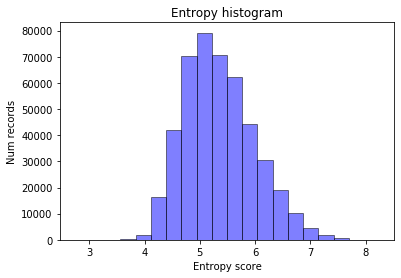

In [ ]:
# Create a histogram of the entropy distribution
plt.hist(java_doc_entropies,bins = 20, color="blue", alpha=0.5, edgecolor="black", linewidth=1.0)
plt.title('Entropy histogram')
plt.ylabel("Num records")
plt.xlabel("Entropy score")
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0d9340f240>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0d9340f8d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0d93402e80>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0d9340ff60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0d934182e8>],
 'means': []}

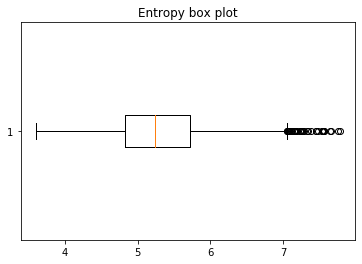

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('Entropy box plot')
ax1.boxplot(java_doc_entropies, vert=False)

## Descriptive metrics

In [ ]:
#Libraries used in ds4se.desc.metrics.java nb

!pip install lizard
!pip install tree_sitter
!pip install bs4

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
from ds4se.desc.metrics import *
from ds4se.desc.metrics.java import *
import lizard
import chardet

In [ ]:
java_src_code_df.head(1)

,code,code_tokens,code_len,partition,data_type
0,"protected final void fastPathOrderedEmit(U value, boolean delayError, Disposable disposable) {\n final Observer<? super V> observer = downstream;\n final SimplePlainQueue<U> q = queue;\n\n if (wip.get() == 0 && wip.compareAndSet(0, 1)) {\n if (q.isEmpty()) {\n ...","[protected, final, void, fastPathOrderedEmit, (, U, value, ,, boolean, delayError, ,, Disposable, disposable, ), {, final, Observer, <, ?, super, V, >, observer, =, downstream, ;, final, SimplePlainQueue, <, U, >, q, =, queue, ;, if, (, wip, ., get, (, ), ==, 0, &&, wip, ., compareAndSet, (, 0, ...",134,test,src


In [ ]:
test_src_code = java_src_code_df['code'].values[0]

In [ ]:
print(test_src_code)

protected final void fastPathOrderedEmit(U value, boolean delayError, Disposable disposable) {
        final Observer<? super V> observer = downstream;
        final SimplePlainQueue<U> q = queue;

        if (wip.get() == 0 && wip.compareAndSet(0, 1)) {
            if (q.isEmpty()) {
                accept(observer, value);
                if (leave(-1) == 0) {
                    return;
                }
            } else {
                q.offer(value);
            }
        } else {
            q.offer(value);
            if (!enter()) {
                return;
            }
        }
        QueueDrainHelper.drainLoop(q, observer, delayError, disposable, this);
    }


Sample of available metrics (for method level)

In [ ]:
metrics = lizard.analyze_file.analyze_source_code('test.java', test_src_code)

In [ ]:
func = metrics.function_list[0]
print('cyclomatic_complexity: {}'.format(func.cyclomatic_complexity))
print('nloc (length): {}'.format(func.length))
print('nloc: {}'.format(func.nloc))
print('parameter_count: {}'.format(func.parameter_count))
print('name: {}'.format(func.name))
print('token_count {}'.format(func.token_count))
print('long_name: {}'.format(func.long_name))

cyclomatic_complexity: 7
nloc (length): 21
nloc: 20
parameter_count: 3
name: fastPathOrderedEmit
token_count 131
long_name: fastPathOrderedEmit( U value , boolean delayError , Disposable disposable)


In [ ]:
def add_method_mccabe_metrics_to_code_df(src_code_df, code_column):
    """Computes method level McCabe metrics and adds it as columns in the specified dataframe"""
    #result_df = src_code_df.copy()
    result_df = pd.DataFrame([])
    
    for index, row in src_code_df.iterrows():
        '''print('index{}'.format(index))
        print('type:{}'.format(type(row[code_column])))'''
        metrics = lizard.analyze_file.analyze_source_code('java_file.java', row[code_column])
        metrics_obj = metrics.function_list
        ''' print('matrics_length', len(metrics_obj))'''
        if(len(metrics_obj) == 0):
            continue
            
        row['cyclomatic_complexity'] = metrics_obj[0].cyclomatic_complexity
        row['nloc'] = metrics_obj[0].nloc
        row['parameter_count'] = metrics_obj[0].parameter_count
        row['method_name'] = metrics_obj[0].name
        row['token_count'] = metrics_obj[0].token_count
                              
        result_df = result_df.append(row)
        '''
        valid_indices.append(index)
        cyclomatic_complexity.append(metrics_obj[0].cyclomatic_complexity)
        nloc.append(metrics_obj[0].nloc)
        parameter_count.append(metrics_obj[0].parameter_count)
        method_name.append(metrics_obj[0].name)
        token_count.append(metrics_obj[0].token_count)'''
    
    '''src_code_df['cyclomatic_complexity'] = cyclomatic_complexity
    src_code_df['nloc'] = nloc
    src_code_df['parameter_count'] = parameter_count
    src_code_df['method_name'] = method_name
    src_code_df['token_count'] = token_count'''
    
    return result_df

In [ ]:
code_df = add_method_mccabe_metrics_to_code_df(java_src_code_df, 'code')

In [ ]:
code_df.shape

(496494, 10)

In [ ]:
code_df.head()

,code,code_len,code_tokens,cyclomatic_complexity,data_type,method_name,nloc,parameter_count,partition,token_count
0,"protected final void fastPathOrderedEmit(U value, boolean delayError, Disposable disposable) {\n final Observer<? super V> observer = downstream;\n final SimplePlainQueue<U> q = queue;\n\n if (wip.get() == 0 && wip.compareAndSet(0, 1)) {\n if (q.isEmpty()) {\n ...",134.0,"[protected, final, void, fastPathOrderedEmit, (, U, value, ,, boolean, delayError, ,, Disposable, disposable, ), {, final, Observer, <, ?, super, V, >, observer, =, downstream, ;, final, SimplePlainQueue, <, U, >, q, =, queue, ;, if, (, wip, ., get, (, ), ==, 0, &&, wip, ., compareAndSet, (, 0, ...",7.0,src,fastPathOrderedEmit,20.0,3.0,test,131.0
1,"@CheckReturnValue\n @NonNull\n @SchedulerSupport(SchedulerSupport.NONE)\n public static <T> Observable<T> amb(Iterable<? extends ObservableSource<? extends T>> sources) {\n ObjectHelper.requireNonNull(sources, ""sources is null"");\n return RxJavaPlugins.onAssembly(new Obser...",63.0,"[@, CheckReturnValue, @, NonNull, @, SchedulerSupport, (, SchedulerSupport, ., NONE, ), public, static, <, T, >, Observable, <, T, >, amb, (, Iterable, <, ?, extends, ObservableSource, <, ?, extends, T, >, >, sources, ), {, ObjectHelper, ., requireNonNull, (, sources, ,, ""sources is null"", ), ;,...",1.0,src,amb,4.0,1.0,test,43.0
2,"@SuppressWarnings(""unchecked"")\n @CheckReturnValue\n @NonNull\n @SchedulerSupport(SchedulerSupport.NONE)\n public static <T> Observable<T> ambArray(ObservableSource<? extends T>... sources) {\n ObjectHelper.requireNonNull(sources, ""sources is null"");\n int len = sources...",107.0,"[@, SuppressWarnings, (, ""unchecked"", ), @, CheckReturnValue, @, NonNull, @, SchedulerSupport, (, SchedulerSupport, ., NONE, ), public, static, <, T, >, Observable, <, T, >, ambArray, (, ObservableSource, <, ?, extends, T, >, ..., sources, ), {, ObjectHelper, ., requireNonNull, (, sources, ,, ""s...",3.0,src,ambArray,11.0,1.0,test,82.0
3,"@SuppressWarnings({ ""unchecked"", ""rawtypes"" })\n @CheckReturnValue\n @NonNull\n @SchedulerSupport(SchedulerSupport.NONE)\n public static <T> Observable<T> concat(Iterable<? extends ObservableSource<? extends T>> sources) {\n ObjectHelper.requireNonNull(sources, ""sources is nul...",79.0,"[@, SuppressWarnings, (, {, ""unchecked"", ,, ""rawtypes"", }, ), @, CheckReturnValue, @, NonNull, @, SchedulerSupport, (, SchedulerSupport, ., NONE, ), public, static, <, T, >, Observable, <, T, >, concat, (, Iterable, <, ?, extends, ObservableSource, <, ?, extends, T, >, >, sources, ), {, ObjectHe...",1.0,src,concat,4.0,1.0,test,50.0
4,"@SuppressWarnings({ ""unchecked"", ""rawtypes"" })\n @CheckReturnValue\n @NonNull\n @SchedulerSupport(SchedulerSupport.NONE)\n public static <T> Observable<T> concat(ObservableSource<? extends ObservableSource<? extends T>> sources, int prefetch) {\n ObjectHelper.requireNonNull(so...",91.0,"[@, SuppressWarnings, (, {, ""unchecked"", ,, ""rawtypes"", }, ), @, CheckReturnValue, @, NonNull, @, SchedulerSupport, (, SchedulerSupport, ., NONE, ), public, static, <, T, >, Observable, <, T, >, concat, (, ObservableSource, <, ?, extends, ObservableSource, <, ?, extends, T, >, >, sources, ,, int...",1.0,src,concat,5.0,2.0,test,62.0


In [ ]:
code_df.to_csv('test_data/clean_java.csv')

In [ ]:
code_df.shape

(4695, 9)

In [ ]:
java_code_df.shape

(4697, 4)

In [ ]:
code_df.head()

,code,code_tokens,code_len,data_type,cyclomatic_complexity,nloc,parameter_count,method_name,token_count
348,"protected void unsetAuthDataService(ServiceReference<AuthDataService> ref) {\n if (TraceComponent.isAnyTracingEnabled() && tc.isDebugEnabled())\n Tr.debug(tc, ""unsetAuthDataService"", ref);\n authDataServiceRef.unsetReference(ref);\n }","[protected, void, unsetAuthDataService, (, ServiceReference, <, AuthDataService, >, ref, ), {, if, (, TraceComponent, ., isAnyTracingEnabled, (, ), &&, tc, ., isDebugEnabled, (, ), ), Tr, ., debug, (, tc, ,, ""unsetAuthDataService"", ,, ref, ), ;, authDataServiceRef, ., unsetReference, (, ref, ), ...",44,src,3,5,1,unsetAuthDataService,42
5389,"@Override\n protected void deltaStartWorkAccepted()\n {\n if (trace)\n log.trace(""deltaStartWorkAccepted"");\n\n super.deltaStartWorkAccepted();\n\n if (distributedStatisticsEnabled && distributedStatistics != null && transport != null)\n {\n try\n ...","[@, Override, protected, void, deltaStartWorkAccepted, (, ), {, if, (, trace, ), log, ., trace, (, ""deltaStartWorkAccepted"", ), ;, super, ., deltaStartWorkAccepted, (, ), ;, if, (, distributedStatisticsEnabled, &&, distributedStatistics, !=, null, &&, transport, !=, null, ), {, try, {, checkTran...",75,src,6,18,0,deltaStartWorkAccepted,71
10500,"private void validateBlockSize(byte[] descriptor) throws IOException {\n int blockSize = Util.getUInt16Both(descriptor, 129);\n if (blockSize != Constants.DEFAULT_BLOCK_SIZE) {\n throw new LoopFileSystemException(""Invalid block size: "" + blockSize);\n }\n }","[private, void, validateBlockSize, (, byte, [, ], descriptor, ), throws, IOException, {, int, blockSize, =, Util, ., getUInt16Both, (, descriptor, ,, 129, ), ;, if, (, blockSize, !=, Constants, ., DEFAULT_BLOCK_SIZE, ), {, throw, new, LoopFileSystemException, (, ""Invalid block size: "", +, blockS...",44,src,2,6,1,validateBlockSize,42
7146,public PooledConnection getConnection(long wait) throws SQLException {\r\n\t\ttry {\r\n\t\t\treturn getConnectionDirect();\r\n\t\t} catch (Exception e) {\r\n\t\t\tThreadUtil.sleep(wait);\r\n\t\t}\r\n\t\treturn getConnectionDirect();\r\n\t},"[public, PooledConnection, getConnection, (, long, wait, ), throws, SQLException, {, try, {, return, getConnectionDirect, (, ), ;, }, catch, (, Exception, e, ), {, ThreadUtil, ., sleep, (, wait, ), ;, }, return, getConnectionDirect, (, ), ;, }]",38,src,2,8,1,getConnection,36
14642,"public boolean addSnomedId(final Candidate candidate) throws SQLException {\n final SnomedTerm result = findFromCuiAndDesc(candidate.getCandidateCUI(), candidate.getCandidatePreferred());\n if (result != null) {\n candidate.setSnomedId(result.snomedId);\n cand...","[public, boolean, addSnomedId, (, final, Candidate, candidate, ), throws, SQLException, {, final, SnomedTerm, result, =, findFromCuiAndDesc, (, candidate, ., getCandidateCUI, (, ), ,, candidate, ., getCandidatePreferred, (, ), ), ;, if, (, result, !=, null, ), {, candidate, ., setSnomedId, (, re...",88,src,2,13,1,addSnomedId,85


In [ ]:
code_df.describe()

,code_len,cyclomatic_complexity,nloc,parameter_count,token_count
count,4697.000000,4697.000000,4697.000000,4697.000000,4697.000000
mean,109.542048,3.700660,14.520971,1.637215,104.443049
std,155.926177,6.155238,20.915982,1.399517,152.802563
min,22.000000,1.000000,3.000000,0.000000,8.000000
25%,42.000000,1.000000,6.000000,1.000000,37.000000
50%,65.000000,2.000000,9.000000,1.000000,61.000000
75%,121.000000,4.000000,16.000000,2.000000,117.000000
max,2707.000000,182.000000,478.000000,16.000000,2678.000000


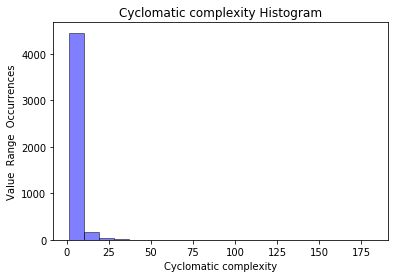

In [ ]:
display_numeric_col_hist(code_df['cyclomatic_complexity'], 'Cyclomatic complexity')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0d93270ac8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0d9327d208>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0d93270978>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0d9327d898>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0d9327dbe0>],
 'means': []}

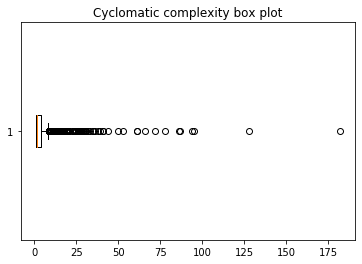

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('Cyclomatic complexity box plot')
ax1.boxplot(code_df['cyclomatic_complexity'], vert=False)

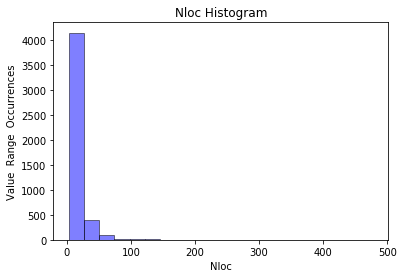

In [ ]:
display_numeric_col_hist(code_df['nloc'], 'Nloc')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0d931094a8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0d93109ba8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0d93109358>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0d93113278>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0d931135c0>],
 'means': []}

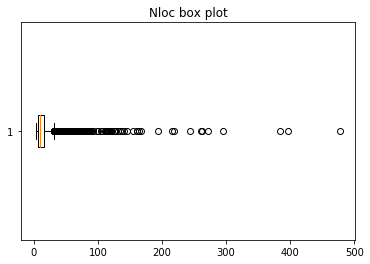

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('Nloc box plot')
ax1.boxplot(code_df['nloc'], vert=False)

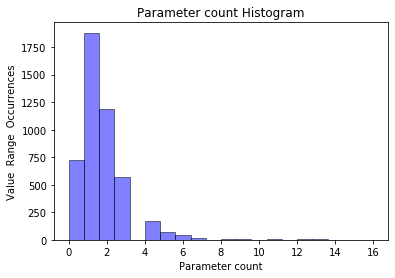

In [ ]:
display_numeric_col_hist(code_df['parameter_count'], 'Parameter count')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0d930defd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0d930ea6a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0d93138320>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0d930ead30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0d930f60b8>],
 'means': []}

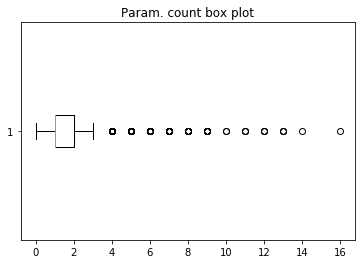

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('Param. count box plot')
ax1.boxplot(code_df['parameter_count'], vert=False)

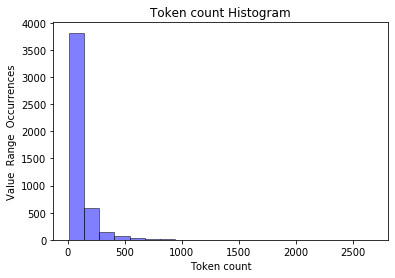

In [ ]:
display_numeric_col_hist(code_df['token_count'], 'Token count')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0d93047908>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0d93047f98>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0d93047588>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0d93055668>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0d930559b0>],
 'means': []}

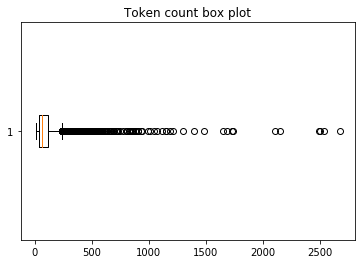

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('Token count box plot')
ax1.boxplot(code_df['token_count'], vert=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0d932c35c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0d932c3c88>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0d932c3240>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0d932cc358>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0d932cc6a0>],
 'means': []}

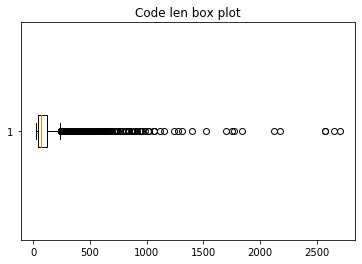

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('Code len box plot')
ax1.boxplot(code_df['code_len'], vert=False)

In [ ]:
code_df.shape

(4697, 9)

In [ ]:
code_df[['cyclomatic_complexity', 'nloc', 'token_count', 'parameter_count']].corr()

,cyclomatic_complexity,nloc,token_count,parameter_count
cyclomatic_complexity,1.000000,0.884579,0.848237,0.039674
nloc,0.884579,1.000000,0.948441,0.076593
token_count,0.848237,0.948441,1.000000,0.124464
parameter_count,0.039674,0.076593,0.124464,1.000000


In [ ]:
import seaborn as sns
import numpy as np

In [ ]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order', 'xlabel', 'ylabel'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    ax.set_xlabel(kwargs.get('xlabel', ''))
    ax.set_ylabel(kwargs.get('ylabel', ''))

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 

    

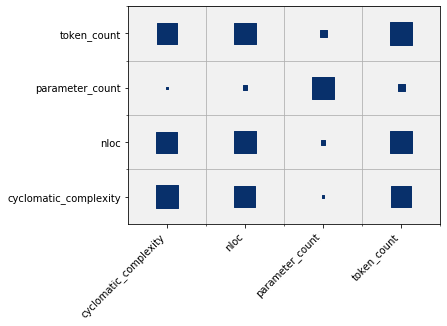

In [ ]:
columns = ['cyclomatic_complexity', 'nloc', 'token_count', 'parameter_count']
corr = code_df[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

In [ ]:
def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index').replace(np.nan, 0)
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

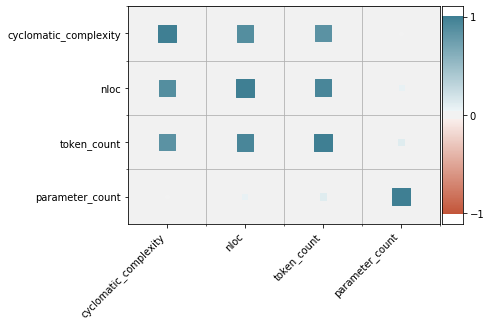

In [ ]:
corrplot(code_df[columns].corr(), size_scale=300);